Assignment 2

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datasets import MNISTDataset
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.0


In [3]:
# basic MNIST

# same thing we had earlier -- this just loads the numpy arrays
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

train_images = train_images.reshape([-1,784])
train_images = train_images.astype(np.float32) / 255

test_images = test_images.reshape([-1,784])
test_images = test_images.astype(np.float32) / 255

test_labels = tf.cast(test_labels,tf.int32)

# this is now different - using from_tensor_slices
train_data = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

#print(train_data)
batch_size = 128

# train_data = train_data.shuffle(6000)
# train_data = train_data.batch(batch_size)
# train_data =train_data.repeat()

train_data = train_data.shuffle(6000)
train_data =train_data.repeat()
train_data = train_data.batch(batch_size)


def get_train_data():
  while True:
    for img, lbl in train_data:
      if len(lbl) != batch_size:
        print("Starting new epoch...")
      yield img, tf.cast(lbl,tf.int32) #tf.cast(img, tf.float32), tf.cast(lbl,tf.float32)




11493376/11490434 [==============================] - 0s 0us/step


In [4]:
""" 
function generating the weights and paramters the network.
inputs = 784 for MNIST data set.
min_val & max_val specify the range for weights initialization.
bias_val = To initialize the biases.
hidden_units is a list that contain no. of neuron at each hidden layer.
"""
def network_generation(inputs, min_val, max_val, bias_val, hidden_units = [200,100,50]):
    j = 1
    weight_lst = [] 
    bias_lst = [] 
    weight_dict = {}
    bias_dict = {}
    for neuron in hidden_units:
      weight_lst.append('w_%d'%j)
      bias_lst.append('b_%d'%j)
      j+=1

    for param in range(len(weight_lst)):
      neuron = hidden_units[param]
      weight_dict[weight_lst[param]] = tf.Variable(tf.random.uniform(shape=[inputs, neuron], minval=min_val, maxval=max_val, dtype=tf.float32))
      bias_dict[bias_lst[param]] = tf.Variable(tf.constant(bias_val, shape=neuron, dtype=tf.float32))
      inputs = neuron

    return weight_dict, bias_dict

In [5]:
# sample o/p for function network_generation for network with 2 hidden units and 2 neurons each.
hidden_unit = [2,2]
weight_dict , bias_dict = network_generation(784,-0.1,0.1,1,hidden_unit)
print(weight_dict)
print(bias_dict)

{'w_1': <tf.Variable 'Variable:0' shape=(784, 2) dtype=float32, numpy=
array([[ 0.03359837, -0.0672034 ],
       [ 0.04090955,  0.07587216],
       [ 0.08511556, -0.05583179],
       ...,
       [-0.0756381 , -0.06121705],
       [ 0.03912594,  0.09068825],
       [-0.06749456, -0.03196897]], dtype=float32)>, 'w_2': <tf.Variable 'Variable:0' shape=(2, 2) dtype=float32, numpy=
array([[ 0.08135564, -0.06417499],
       [-0.04378347, -0.05024562]], dtype=float32)>}
{'b_1': <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>, 'b_2': <tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([1., 1.], dtype=float32)>}


In [11]:
gen_train_data = get_train_data() # Generator Object.
#print(next(gen_train_data))

""" function for forward_prop """

def forward_prop(train_steps, hidden_units, weight_dict, bias_dict, activation, W_out, b_out):

    step_accuracy = []
    step_loss = []
    setp_epoch = []

    for step in range(train_steps):
      img_batch, lbl_batch = next(gen_train_data) #data.next_batch()

      hidden = list()
      with tf.GradientTape() as tape:
        for i in range(len(hidden_units)):
          hidden.append(activation(tf.matmul(img_batch, weight_dict[list(weight_dict.keys())[i]]) + bias_dict[list(bias_dict.keys())[i]]))
          img_batch = hidden[i]

        out = tf.matmul(hidden[-1], W_out) + b_out
        xent = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=out, labels=lbl_batch))

        weights = [weight_dict[k] for k in list(weight_dict.keys())]
        biases = [bias_dict[k] for k in list(bias_dict.keys())]

        total_layer =  weights + biases + [W_out, b_out]
        grads = tape.gradient(xent, total_layer)
        
        weight_grad = 0
        for k,v in weight_dict.items():
            weight_dict[k].assign_sub(learning_rate * grads[weight_grad])
            weight_grad+=1

        for k,v in bias_dict.items():
            bias_dict[k].assign_sub(learning_rate * grads[weight_grad])
            weight_grad+=1
        
        W_out.assign_sub(learning_rate * grads[weight_grad])
        weight_grad+=1
        b_out.assign_sub(learning_rate * grads[weight_grad])

        if not step % 100:
            preds = tf.argmax(out, axis=1, output_type=tf.int32)
            acc = tf.reduce_mean(tf.cast(tf.equal(preds, lbl_batch),
                                tf.float32))
            print("Loss: {} Accuracy: {}".format(xent, acc))
            step_accuracy.append(acc)
            step_loss.append(xent)
            setp_epoch.append(step)
        
    return step_accuracy, step_loss, setp_epoch, weight_dict, bias_dict, W_out, b_out

In [12]:
""" function for to calculate Accuracy on testing data."""
def prediction( hidden_units, weight_dict, bias_dict, activation, W_out, b_out):
    hidden = list()
    #img_batch = data.test_data
    img_batch = test_images
    for i in range(len(hidden_units)):
        hidden.append(activation(tf.matmul(img_batch, weight_dict[list(weight_dict.keys())[i]]) + bias_dict[list(bias_dict.keys())[i]]))
        img_batch = hidden[i]

    out = tf.matmul(hidden[-1], W_out) + b_out

    test_preds = tf.argmax(tf.matmul(hidden[-1], W_out) + b_out, axis=1, output_type=tf.int32)
    
    acc = tf.reduce_mean(tf.cast(tf.equal(test_preds, test_labels) ,tf.float32))
    print("Accuracy on prediction data: ",acc)

Below is the network containing a single hidden layer of 200 neurons.
Activation function: relu


In [16]:
num_class = 10
train_steps = 7000
learning_rate = 0.1
hidden_units = [200]
activation = tf.nn.relu


W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)
prediction( hidden_units, weight, bias, activation, out_wt, out_bias)


Loss: 43.9923095703125 Accuracy: 0.15625
Loss: 2.3483128547668457 Accuracy: 0.796875
Loss: 1.1942014694213867 Accuracy: 0.8515625
Loss: 0.9907293319702148 Accuracy: 0.8984375
Loss: 1.6926934719085693 Accuracy: 0.7890625
Loss: 0.4102671146392822 Accuracy: 0.921875
Loss: 0.9568743705749512 Accuracy: 0.8671875
Loss: 0.5431733727455139 Accuracy: 0.9140625
Loss: 0.45439550280570984 Accuracy: 0.921875
Loss: 0.6448560357093811 Accuracy: 0.9140625
Loss: 0.6465226411819458 Accuracy: 0.9140625
Loss: 0.4082590341567993 Accuracy: 0.9140625
Loss: 0.43525904417037964 Accuracy: 0.921875
Loss: 0.4666490852832794 Accuracy: 0.921875
Loss: 0.16829346120357513 Accuracy: 0.96875
Loss: 0.7466819882392883 Accuracy: 0.9375
Loss: 0.42498233914375305 Accuracy: 0.9375
Loss: 0.6291946172714233 Accuracy: 0.8828125
Loss: 0.4810710549354553 Accuracy: 0.90625
Loss: 0.4022447168827057 Accuracy: 0.9296875
Loss: 0.20951053500175476 Accuracy: 0.9375
Loss: 0.1041230708360672 Accuracy: 0.9765625
Loss: 0.30572861433029175 A

In [17]:
def plotgraph(plots):
    for i in [0,1 ]:
      fig = plt.figure(figsize=(15,5))
      ax = fig.add_subplot(1,3,i+1)
      ax.grid()
      plt.plot(epoch, plots[i])
      plt.show()

Graphs for Accuracy and Loss values

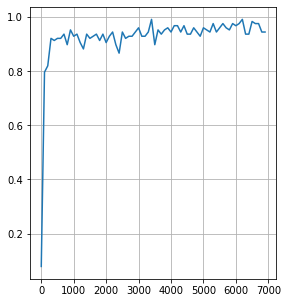

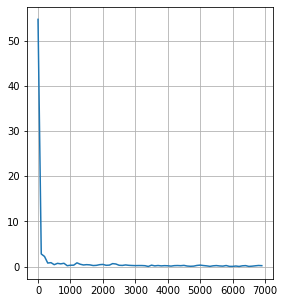

In [ ]:
plotgraph([accuracy, loss])

Below is the network consisting of 2 hidden layers of 50 and 200 neurons, trained for 4000 epochs, with the learning rate of 0.1
Activation function: relu

In [18]:
num_class = 10
train_steps = 4000
learning_rate = 0.1
hidden_units = [50,200]
activation = tf.nn.relu

W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 123.9588851928711 Accuracy: 0.0546875
Loss: 1.9465534687042236 Accuracy: 0.3203125
Loss: 1.8438446521759033 Accuracy: 0.3515625
Loss: 1.564421534538269 Accuracy: 0.4140625
Loss: 1.5792043209075928 Accuracy: 0.4765625
Loss: 1.5324416160583496 Accuracy: 0.5
Loss: 1.44809889793396 Accuracy: 0.4921875
Loss: 1.0860916376113892 Accuracy: 0.59375
Loss: 1.1880557537078857 Accuracy: 0.6171875
Loss: 1.0643659830093384 Accuracy: 0.6875
Loss: 1.2567121982574463 Accuracy: 0.5546875
Loss: 1.0782568454742432 Accuracy: 0.6015625
Loss: 0.8090471029281616 Accuracy: 0.7421875
Loss: 0.8536767363548279 Accuracy: 0.6796875
Loss: 0.9526666402816772 Accuracy: 0.6015625
Loss: 0.7100547552108765 Accuracy: 0.7578125
Loss: 1.1443452835083008 Accuracy: 0.640625
Loss: 0.8871350288391113 Accuracy: 0.6875
Loss: 1.0459545850753784 Accuracy: 0.6796875
Loss: 0.6364239454269409 Accuracy: 0.78125
Loss: 0.8891313076019287 Accuracy: 0.7265625
Loss: 0.6410452723503113 Accuracy: 0.75
Loss: 0.7496203780174255 Accuracy: 0

Plots for the accurcy and loss for training data for the above trained network

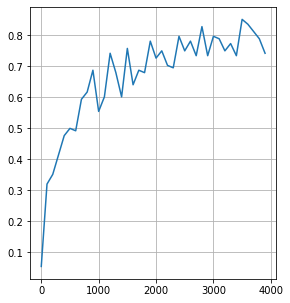

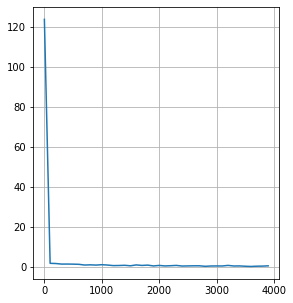

In [19]:
plotgraph([accuracy, loss])

Network with three hidden units consiting of 50,150 and 200 neurons, with the learning rate value of 0.01 , trained for 4000 epochs.
Activation function: tanh

In [20]:
num_class = 10
train_steps = 4000
learning_rate = 0.01
hidden_units = [50,150,200]
activation = tf.nn.tanh

W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps,hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 11.98684310913086 Accuracy: 0.1875
Loss: 6.908517837524414 Accuracy: 0.21875
Loss: 4.145108699798584 Accuracy: 0.4140625
Loss: 3.7742555141448975 Accuracy: 0.4140625
Loss: 3.0443530082702637 Accuracy: 0.5234375
Loss: 2.369861602783203 Accuracy: 0.5703125
Loss: 2.490365505218506 Accuracy: 0.53125
Loss: 2.02473783493042 Accuracy: 0.609375
Loss: 2.632570743560791 Accuracy: 0.5625
Loss: 2.2288756370544434 Accuracy: 0.546875
Loss: 2.1552157402038574 Accuracy: 0.640625
Loss: 2.8143253326416016 Accuracy: 0.6015625
Loss: 1.8328397274017334 Accuracy: 0.6796875
Loss: 2.2334699630737305 Accuracy: 0.625
Loss: 1.9661054611206055 Accuracy: 0.65625
Loss: 1.620052695274353 Accuracy: 0.734375
Loss: 1.4018245935440063 Accuracy: 0.65625
Loss: 1.282778263092041 Accuracy: 0.7265625
Loss: 1.42667555809021 Accuracy: 0.7265625
Loss: 1.287994623184204 Accuracy: 0.734375
Loss: 1.00263249874115 Accuracy: 0.7578125
Loss: 1.4113738536834717 Accuracy: 0.703125
Loss: 1.8931961059570312 Accuracy: 0.6796875
Loss

Plots depicting the accuracy and loss value for the above network.

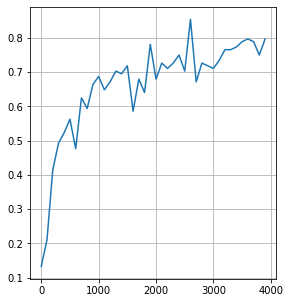

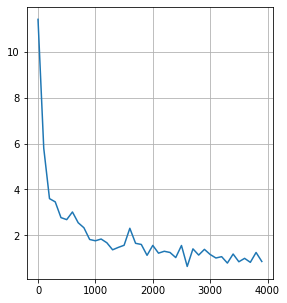

In [ ]:
plotgraph([accuracy, loss])

**MNIST Fashion Data set** 

4423680/4422102 [==============================] - 0s 0us/step


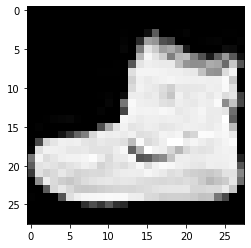

In [ ]:
mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

plt.imshow(train_images[0], cmap="Greys_r")

data = MNISTDataset(train_images.reshape([-1, 784]), train_labels, 
                    test_images.reshape([-1, 784]), test_labels,
                    batch_size=128)

In [ ]:
num_class = 10
train_steps = 4000
learning_rate = 0.01
hidden_units = [200]
activation = tf.nn.relu

W_out = tf.Variable(tf.random.uniform(shape=[200, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

Loss: 46.86957550048828 Accuracy: 0.140625
Starting new epoch...
Loss: 9.045614242553711 Accuracy: 0.4765625
Loss: 6.500672340393066 Accuracy: 0.6015625
Loss: 5.517440319061279 Accuracy: 0.6640625
Loss: 3.848068952560425 Accuracy: 0.71875
Starting new epoch...
Loss: 1.9053575992584229 Accuracy: 0.828125
Loss: 2.964489221572876 Accuracy: 0.8125
Loss: 3.7062649726867676 Accuracy: 0.7421875
Loss: 1.99020516872406 Accuracy: 0.7734375
Loss: 1.7612535953521729 Accuracy: 0.828125
Starting new epoch...
Loss: 1.6262128353118896 Accuracy: 0.8515625
Loss: 2.420034646987915 Accuracy: 0.8203125
Loss: 1.7178643941879272 Accuracy: 0.828125
Loss: 1.0525093078613281 Accuracy: 0.8828125
Loss: 1.5351531505584717 Accuracy: 0.8828125
Starting new epoch...
Loss: 2.389589309692383 Accuracy: 0.8203125
Loss: 1.177825689315796 Accuracy: 0.8515625
Loss: 1.0572326183319092 Accuracy: 0.8046875
Loss: 2.1848974227905273 Accuracy: 0.7890625
Starting new epoch...
Loss: 0.7021768093109131 Accuracy: 0.875
Loss: 1.942218

InvalidArgumentError: ignored

In [ ]:
plotgraph([accuracy, loss])

In [ ]:
plotgraph([accuracy,loss])

In [ ]:
num_class = 10
train_steps = 4000
learning_rate = 0.1
hidden_units = [50, 150]
activation = tf.nn.tanh

W_out = tf.Variable(tf.random.uniform(shape=[150, num_class], minval=-1, maxval=1, dtype=tf.float32))
b_out = tf.Variable(tf.constant(0, shape=num_class, dtype=tf.float32))

weight_dict, bias_dict = network_generation(784, -1, 1, 0, hidden_units)
accuracy, loss, epoch, weight, bias, out_wt, out_bias = forward_prop(train_steps, data, hidden_units, weight_dict, bias_dict, activation, W_out, b_out)

prediction(data, hidden_units, weight, bias, activation, out_wt, out_bias)

In [ ]:
plotgraph([accuracy,loss])

currently we are making the network by defining the architecture manually multiplying the weights with the input and passing this as input to the next layer, this entire
functionality in one function.

Parameters such as num_hidden layers, epochs, learning_rate should not be defined again and again, rather should be coming from a config, where changing the values in function 
should be able to run the training.